In [1]:
import numpy as np
import pandas as pd
import re
import os

import textblob
from textblob import TextBlob, Word

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.cbook import boxplot_stats
import seaborn as sns

In [2]:
#load app reviews into dataframe
apps = pd.read_csv('appdetails/App_Details_new.csv')
reviews = pd.read_csv('reviews_opioid.csv')
merged_df = pd.merge(apps, reviews, on = 'appId', how = "inner")

print(merged_df.shape)
print(merged_df.head(5))

(9491, 22)
                                       title  \
0  23andMe - DNA Testing : Health & Ancestry   
1  23andMe - DNA Testing : Health & Ancestry   
2  23andMe - DNA Testing : Health & Ancestry   
3  23andMe - DNA Testing : Health & Ancestry   
4  23andMe - DNA Testing : Health & Ancestry   

                                         description    installs  ratings  \
0  Explore your DNA with 23andMe. Discover how yo...  1,000,000+  22449.0   
1  Explore your DNA with 23andMe. Discover how yo...  1,000,000+  22449.0   
2  Explore your DNA with 23andMe. Discover how yo...  1,000,000+  22449.0   
3  Explore your DNA with 23andMe. Discover how yo...  1,000,000+  22449.0   
4  Explore your DNA with 23andMe. Discover how yo...  1,000,000+  22449.0   

   score_x  reviews             genre  containsAds                     appId  \
0     4.75   7228.0  Health & Fitness        False  com.twentythreeandme.app   
1     4.75   7228.0  Health & Fitness        False  com.twentythreeandme.app 

In [3]:
#get list of apps to be excluded
apps_to_exclude = []
for line in open('appsToExclude.txt', 'r'):
    apps_to_exclude.append(line.strip())

In [4]:
#drop the rows from reviews df for the apps in apps_to_exclude list
for app in apps_to_exclude:
    merged_df.drop(reviews[reviews['appId'] == app].index, inplace=True, errors='ignore')

print(merged_df.shape)

(1377, 22)


<AxesSubplot:>

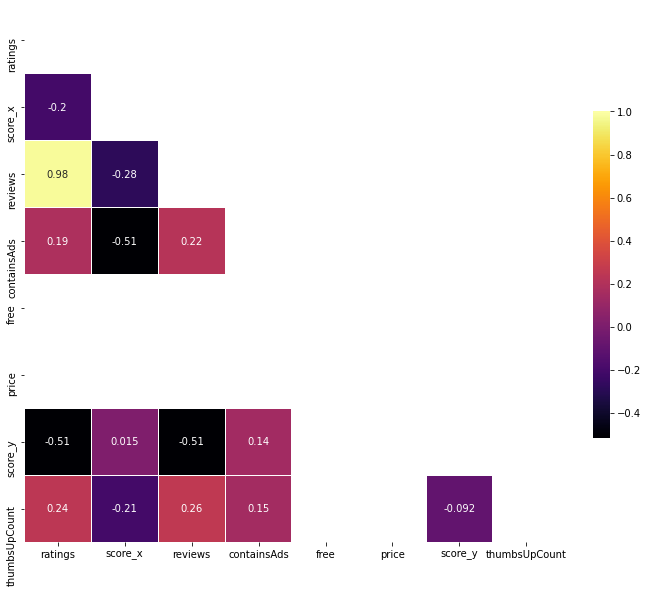

In [5]:
colormap = plt.cm.inferno
mask = np.triu(np.ones_like(merged_df.corr(), dtype=bool))
plt.figure(figsize=(12,12))
sns.heatmap(merged_df.corr(), mask=mask, linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True, cbar_kws={"shrink": .5})

In [6]:
#Pre-Processing of Review Comments - clean up of punctuation, white space
REPLACE_NO_SPACE = re.compile("(\.)|(\;)|(\:)|(\!)|(\')|(\?)|(\,)|(\")|(\()|(\))|(\[)|(\])|(\d+)")
REPLACE_WITH_SPACE = re.compile("(<br\s*/><br\s*/>)|(\-)|(\/)")
NO_SPACE = ""
SPACE = " "

def preprocess_reviews(text):
    
    processed_text = [REPLACE_NO_SPACE.sub(NO_SPACE, line.lower()) for line in text]
    processed_text = [REPLACE_WITH_SPACE.sub(SPACE, line) for line in text]
    processed_text = [TextBlob(line).correct for line in text]
    
    return processed_text

merged_df['processed_review'] = preprocess_reviews(merged_df['content'].astype(str))
print(merged_df.shape)

(1377, 23)


In [7]:
def polarity(text: str) -> float:
    return TextBlob(text).sentiment.polarity

def subjectivity(text: str) -> float:
    return TextBlob(text).sentiment.subjectivity

merged_df['polarity'] = merged_df['processed_review'].astype(str).apply(polarity)
merged_df['subjectivity'] = merged_df['processed_review'].astype(str).apply(subjectivity)
print(merged_df.head(5))

                                       title  \
0  23andMe - DNA Testing : Health & Ancestry   
1  23andMe - DNA Testing : Health & Ancestry   
2  23andMe - DNA Testing : Health & Ancestry   
3  23andMe - DNA Testing : Health & Ancestry   
4  23andMe - DNA Testing : Health & Ancestry   

                                         description    installs  ratings  \
0  Explore your DNA with 23andMe. Discover how yo...  1,000,000+  22449.0   
1  Explore your DNA with 23andMe. Discover how yo...  1,000,000+  22449.0   
2  Explore your DNA with 23andMe. Discover how yo...  1,000,000+  22449.0   
3  Explore your DNA with 23andMe. Discover how yo...  1,000,000+  22449.0   
4  Explore your DNA with 23andMe. Discover how yo...  1,000,000+  22449.0   

   score_x  reviews             genre  containsAds                     appId  \
0     4.75   7228.0  Health & Fitness        False  com.twentythreeandme.app   
1     4.75   7228.0  Health & Fitness        False  com.twentythreeandme.app   
2     4.

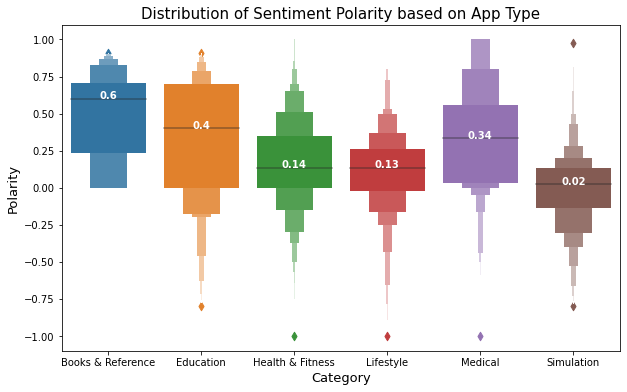

In [24]:
plt.figure(figsize=(10,6))
boxenplot = sns.boxenplot(x='genre', y='polarity', data=merged_df)

medians = merged_df.groupby(['genre'])['polarity'].median().values
median_labels = [str(np.round(s, 2)) for s in medians]
pos = range(len(medians))

for tick,label in zip(pos, boxenplot.get_xticklabels()):
    boxenplot.text(pos[tick], medians[tick], median_labels[tick], horizontalalignment='center', color='w', weight='semibold')
    
plt.xlabel('Category', fontsize=13)
plt.ylabel('Polarity', fontsize=13)
plt.title('Distribution of Sentiment Polarity based on App Type', fontsize=15)
plt.show()

In [16]:
merged_df['genre'] = merged_df['genre'].astype('category')
boxplot = pd.DataFrame()
boxplot['mean'] = merged_df.groupby(['genre'])['polarity'].mean()
boxplot['median'] = merged_df.groupby(['genre'])['polarity'].median()
boxplot['25th'] = merged_df.groupby(['genre'])['polarity'].quantile(0.25)
boxplot['75th'] = merged_df.groupby(['genre'])['polarity'].quantile(0.75)
boxplot['pos_pol'] = merged_df[merged_df['polarity'] > 0].groupby(['genre']).size()
boxplot['neg_pol'] = merged_df[merged_df['polarity'] <= 0].groupby(['genre']).size()
boxplot['apps'] = merged_df.groupby(['genre']).appId.nunique()
#outliers = [y for stat in boxplot_stats(reviews['polarity']) for y in stat['fliers']]
print (boxplot)
#print(outliers)

                       mean    median      25th      75th  pos_pol  neg_pol  \
genre                                                                         
Books & Reference  0.484762  0.600000  0.233333  0.708333        5        2   
Education          0.306172  0.400000  0.000000  0.700000       12        7   
Health & Fitness   0.159005  0.136364  0.000000  0.350000      463      264   
Lifestyle          0.107953  0.133482 -0.020000  0.260417       76       36   
Medical            0.343825  0.335000  0.030357  0.559028      319      105   
Simulation        -0.006532  0.025000 -0.135069  0.134167       45       43   

                   apps  
genre                    
Books & Reference     1  
Education             1  
Health & Fitness      4  
Lifestyle             1  
Medical               9  
Simulation            1  


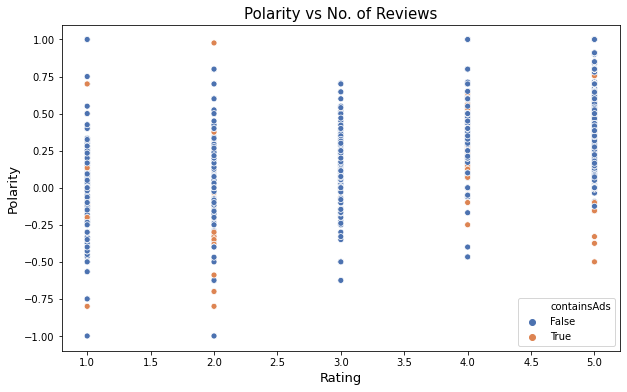

In [17]:
plt.figure(figsize=(10,6))
sns.scatterplot(x='score_y', y='polarity', hue="containsAds", data=merged_df, palette="deep")
plt.xlabel('Rating', fontsize=13)
plt.ylabel('Polarity', fontsize=13)
plt.title('Polarity vs No. of Reviews', fontsize=15)
plt.show()

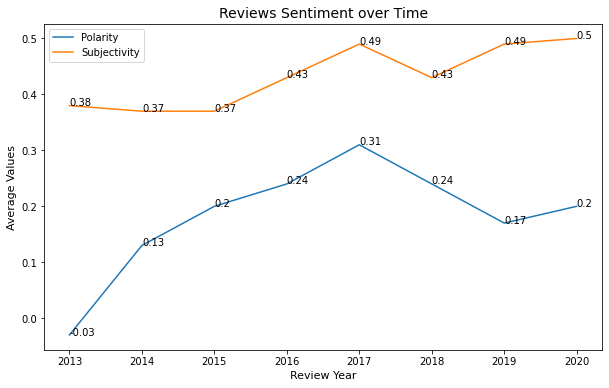

In [20]:
merged_df['at'] = pd.to_datetime(merged_df['at'])
merged_df['review_year'] = pd.DatetimeIndex(merged_df['at']).year

pol_mean = np.round(merged_df.groupby(['review_year'])['polarity'].mean(),2)
sub_mean = np.round(merged_df.groupby(['review_year'])['subjectivity'].mean(),2)

plt.figure(figsize=(10,6))

ax1 = pol_mean.plot()
for i,j in pol_mean.items():
    ax1.annotate(str(j), xy=(i, j))

ax2 = sub_mean.plot()
for i,j in sub_mean.items():
    ax2.annotate(str(j), xy=(i, j))

plt.xlabel('Review Year', fontsize=11)
plt.ylabel('Average Values', fontsize=11)
plt.title("Reviews Sentiment over Time", fontsize=14)
plt.legend(['Polarity', 'Subjectivity'], loc='upper left')